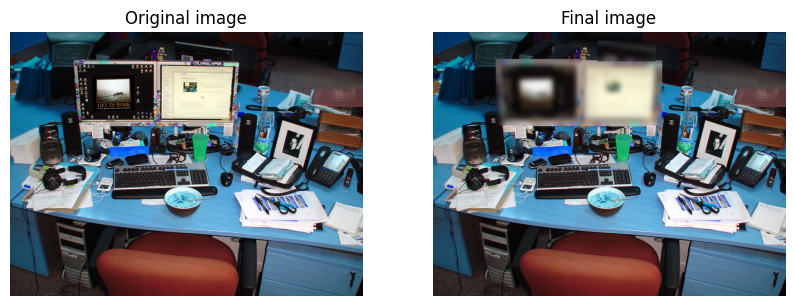

In [ ]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
from rich.progress import track

from file_processing import *

model = YOLO("yolo12x.pt")

items_to_blur = [62, 63] # tv, laptop
input_path = Path().parent / "tests" / "images" / "low_res.jpg"
blur_coefficient = 49

original_image = cv2.imread(input_path)
final_low_res = original_image.copy()
results = model(final_low_res, verbose=False)

def blur_function(roi):
    return cv2.GaussianBlur(roi, (blur_coefficient, blur_coefficient), 0)

blur_items(results[0], items_to_blur, final_low_res, blur_function)

fig, axes = plt.subplots(1, 2, figsize=(10, 10))

axes[0].imshow(original_image)
axes[0].set_title('Original image')
axes[0].axis('off')

axes[1].imshow(final_low_res)
axes[1].set_title('Final image')
axes[1].axis('off')

plt.show()

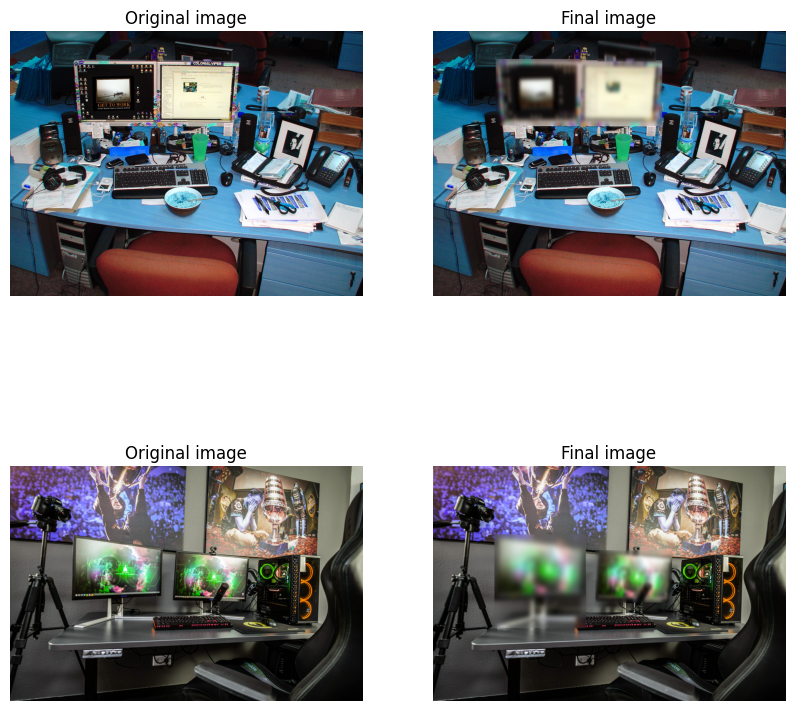

In [46]:
def blur_function(roi):
    blur_coefficient = 0.05 * 3
    h, w = roi.shape[:2]
    ksize = (int(h * blur_coefficient) | 1, int(w * blur_coefficient) | 1)
    return cv2.GaussianBlur(roi, ksize, 0)

items_to_blur = [62, 63] # tv, laptop
blur_coefficient = 49
low_res_path = Path().parent / "tests" / "images" / "low_res.jpg"
high_res_path = Path().parent / "tests" / "images" / "high_res.jpg"
original_low_res = cv2.imread(low_res_path)
original_high_res = cv2.imread(high_res_path)
final_low_res = original_low_res.copy()
final_high_res = original_high_res.copy()

results = model(final_low_res, verbose=False)
blur_items(results[0], items_to_blur, final_low_res, blur_function)

results = model(final_high_res, verbose=False)
blur_items(results[0], items_to_blur, final_high_res, blur_function)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0][0].imshow(original_low_res)
axes[0][0].set_title("Original image")
axes[0][0].axis("off")

axes[0][1].imshow(final_low_res)
axes[0][1].set_title("Final image")
axes[0][1].axis("off")

axes[1][0].imshow(original_high_res)
axes[1][0].set_title("Original image")
axes[1][0].axis("off")

axes[1][1].imshow(final_high_res)
axes[1][1].set_title("Final image")
axes[1][1].axis("off")

plt.show()

In [45]:
names = {
    0: "person",
    1: "bicycle",
    2: "car",
    3: "motorcycle",
    4: "airplane",
    5: "bus",
    6: "train",
    7: "truck",
    8: "boat",
    9: "traffic light",
    10: "fire hydrant",
    11: "stop sign",
    12: "parking meter",
    13: "bench",
    14: "bird",
    15: "cat",
    16: "dog",
    17: "horse",
    18: "sheep",
    19: "cow",
    20: "elephant",
    21: "bear",
    22: "zebra",
    23: "giraffe",
    24: "backpack",
    25: "umbrella",
    26: "handbag",
    27: "tie",
    28: "suitcase",
    29: "frisbee",
    30: "skis",
    31: "snowboard",
    32: "sports ball",
    33: "kite",
    34: "baseball bat",
    35: "baseball glove",
    36: "skateboard",
    37: "surfboard",
    38: "tennis racket",
    39: "bottle",
    40: "wine glass",
    41: "cup",
    42: "fork",
    43: "knife",
    44: "spoon",
    45: "bowl",
    46: "banana",
    47: "apple",
    48: "sandwich",
    49: "orange",
    50: "broccoli",
    51: "carrot",
    52: "hot dog",
    53: "pizza",
    54: "donut",
    55: "cake",
    56: "chair",
    57: "couch",
    58: "potted plant",
    59: "bed",
    60: "dining table",
    61: "toilet",
    62: "tv",
    63: "laptop",
    64: "mouse",
    65: "remote",
    66: "keyboard",
    67: "cell phone",
    68: "microwave",
    69: "oven",
    70: "toaster",
    71: "sink",
    72: "refrigerator",
    73: "book",
    74: "clock",
    75: "vase",
    76: "scissors",
    77: "teddy bear",
    78: "hair drier",
    79: "toothbrush",
}
